# Libraries Needed

In [ ]:
!pip install tensorflow_text transformers
import torch
from transformers import BertTokenizer
from transformers.file_utils import is_tf_available, is_torch_available, is_torch_tpu_available
from transformers import BertTokenizerFast, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
import random
import numpy as np
import io
import os
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
import tensorflow_hub as hub
import tensorflow_text as text
# Text cleaning lib
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
nltk.download('stopwords')
nltk.download('punkt')
# load 20 news groups from sklean dataset 
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
# analytics tools
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error, mean_absolute_error, ConfusionMatrixDisplay
# tensorflow 
import tensorflow as tf
print(tf.__version__)
print(hub.__version__)
print(text.__version__)
print(sys.version)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

     |████████████████████████████████| 4.9 MB 5.4 MB/s 
     |████████████████████████████████| 3.4 MB 32.2 MB/s 
     |████████████████████████████████| 61 kB 478 kB/s 
     |████████████████████████████████| 596 kB 45.3 MB/s 
     |████████████████████████████████| 895 kB 39.5 MB/s 
     |████████████████████████████████| 3.3 MB 38.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
2.7.0
0.12.0
2.7.3
3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]


# Utils

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
def clean_text(text):
  """
  text: a string
        
  return: modified initial string
  """
  stemmer = PorterStemmer()
  REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
  BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
  STOPWORDS = set(stopwords.words('english'))
  REMOVE_NUM = re.compile('[\d+]')
  text = text.lower() # lowercase text
  text = REPLACE_BY_SPACE_RE.sub(' ', text)
  text = text.replace('.', ' ')
  text = BAD_SYMBOLS_RE.sub('', text)
  text = text.replace('x', '')
  text = REMOVE_NUM.sub('', text)
  # delete stopwords from text
  text = ' '.join(word for word in text.split() if word not in STOPWORDS) 
  # Stemming the words
  text = ' '.join([stemmer.stem(word) for word in text.split()])
  return text

#Program 1 - Text classification

The objective is to design a deep learning model capable of classifying texts
into 10 classes, predicting the class of newsgroups to which a text belongs
Data are available in the UC Irvine - Machine Learning Repository

* Consider only the 10 classes with the largest number of data samples
Models like the ones seen during the lab sessions; Transformer models; Transfer Learning \

## Data Preprocessing

In [ ]:
# vars 
VOCAB_SIZE = 500
EMB_DIM = 128
MAX_SIZE = 100
# according to this message https://discord.com/channels/772838799393685544/887243174156836904/920259987740164116
# we will be picking top 10 classes
categories = [
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns'
]
NB_CLASSES = len(categories)
# follow https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_20newsgroups.html
# enabled shuffling so the model won't have to understand and apply same learning rate at each time
data_train = fetch_20newsgroups(subset='train', 
                                categories=categories, 
                                shuffle=True, remove=('headers', 'footers', 'quotes'), random_state=42)
data_test = fetch_20newsgroups(subset='test', 
                                categories=categories, 
                                shuffle=True,remove=('headers', 'footers', 'quotes'), random_state=42)
# split train data with their labels 
X_train = data_train.data
y_train = data_train.target
print(X_train[0])
print(y_train[0])
# split test data with their labels 
X_test = data_test.data
y_test = data_test.target
print(X_test[0])
print(y_test[0])
# finding max size 
# MAX_SIZE = int(max([len(sentence) for sentence in X_train]))
# print("max sentence size is ",MAX_SIZE)
# checking data length compliance we will need it to be same size for embedding puposes
assert(len(X_train) == len(y_train))
assert(len(X_test) == len(y_test))


I can tell you that when AMSAT launched some birds along a Spot satellite
(French), that during installation of some instruments on Spot 2, there
heavily armed legionaires who had a `take no prisoners' look on there faces.
Spot satellites are completely capable of doing some very good on orbit
surveillance.

BMc
--
7



Sure there are quacks. There are quacks who don't treat and quacks who
treat. One's that refuse to diagnose and ones that diagnose improperly. 
There are lucky quacks and unlucky quacks. Smart quacks and dumb ones. 

There are people ahead of their time, with unprobable or unproven theories
and rationals. There are ill-reasoned, absurd, theorists. 

Sometimes it's hard to tell who's who.  

Reading a book of ancient jokes it seems that doctors called other doctors
quacks in Babylon. 

Arguments abound when there aren't any firm answers. Plenty of illnesses
aren't, or can't, be diagnosed or treated. But I think it's better to argue
against the theory, as was originally d

In [ ]:
# Data cleaning
X_train = [clean_text(text) for text in X_train]
X_test = [clean_text(text) for text in X_test]
print(X_train[0])
print(X_test[0])

tell amsat launch bird along spot satellit french instal instrument spot thereheavili arm legionair take prison look face spot satellit complet capabl good orbitsurveil bmc
sure quack quack dont treat quack whotreat one refus diagnos one diagnos improperli lucki quack unlucki quack smart quack dumb one peopl ahead time unprob unproven theoriesand ration illreason absurd theorist sometim hard tell who read book ancient joke seem doctor call doctorsquack babylon argument abound arent firm answer plenti illnessesar cant diagnos treat think better argueagainst theori origin done post candida monthor ago state fact usual work better simpli assert anopinion someon compet cant convinc everybodi sometim correct diagnosistak year peopl dont run doctor recogn thediseas havent develop someth recogniz yet havesometh one go recogn hasnt beendescrib yet sometim get cure sometim ill wear sometim stumbl improp diagnosi right treatment sometim find incur profit patient accept hopeless attitud ill unles

### Tokenize Data

In [ ]:
# tokenizer to tokenize data into value
tokenizer = Tokenizer(num_words = VOCAB_SIZE, oov_token="<OOV>")
# since computer doesnt undrstand text we have to turn words into sequences set of meaningful numbers 
print(len(X_train[0]))
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_train = sequence.pad_sequences(X_train, maxlen=MAX_SIZE, padding="post", truncating="post")
print('X_train shape:',X_train.shape)
print(X_train[0])

172
X_train shape: (5907, 100)
[156   1 209   1   1   1 362   1   1   1   1   1 395   1  45   1  37   1
   1 362 343   1  16   1   1   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]


In [ ]:
# since computer doesnt undrstand text we have to turn words into sequences set of meaningful numbers 
print(X_test[0])
tokenizer.fit_on_texts(X_test)
X_test = tokenizer.texts_to_sequences(X_test)
X_test = sequence.pad_sequences(X_test, maxlen=MAX_SIZE,padding="post", truncating="post")
print('X_test shape:',X_test.shape)
print(X_test[0])

sure quack quack dont treat quack whotreat one refus diagnos one diagnos improperli lucki quack unlucki quack smart quack dumb one peopl ahead time unprob unproven theoriesand ration illreason absurd theorist sometim hard tell who read book ancient joke seem doctor call doctorsquack babylon argument abound arent firm answer plenti illnessesar cant diagnos treat think better argueagainst theori origin done post candida monthor ago state fact usual work better simpli assert anopinion someon compet cant convinc everybodi sometim correct diagnosistak year peopl dont run doctor recogn thediseas havent develop someth recogniz yet havesometh one go recogn hasnt beendescrib yet sometim get cure sometim ill wear sometim stumbl improp diagnosi right treatment sometim find incur profit patient accept hopeless attitud ill unless rock solid diagnosi termin diseas ismor like ly person find cure keep look
X_test shape: (3931, 100)
[ 85   1   1   7   1   1   1   3   1   1   3   1   1   1   1   1   1  

In [ ]:
reverse_word_index = dict([(value, key) for (key, value) in tokenizer.word_index.items()])

def decode_sentence(text):
  return " ".join([reverse_word_index.get(i,'?') for i in text])

print(decode_sentence(X_train[0]))
print(X_train[0])

secur <OOV> bad <OOV> <OOV> <OOV> ecept <OOV> <OOV> <OOV> <OOV> <OOV> increas <OOV> problem <OOV> need <OOV> <OOV> ecept accept <OOV> say <OOV> <OOV> ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
[156   1 209   1   1   1 362   1   1   1   1   1 395   1  45   1  37   1
   1 362 343   1  16   1   1   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]


## Model

In [ ]:
!rm -rf ckpt/

In [ ]:
model = tf.keras.Sequential([
  tf.keras.layers.Embedding(VOCAB_SIZE, EMB_DIM, input_length=MAX_SIZE),
  tf.keras.layers.GlobalAveragePooling1D(),
  tf.keras.layers.Dense(6, activation='relu'),
  tf.keras.layers.Dense(NB_CLASSES, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])
model.summary()
print('Training model')
batch_size = 64
# checkpoint to reserve latest model with best weights and load it and train based on previous values
! mkdir ckpt/
checkpoint_path = "./ckpt/"
ckpt = tf.train.Checkpoint(model)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print("Latest checkpoint restored!!")
#Reduce learning rate when a metric has stopped improving.
history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=30,
          validation_split=0.2,
          callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001), 
                               EarlyStopping(monitor='val_loss', mode='min', patience=2, verbose=1),
                               EarlyStopping(monitor='val_accuracy', mode='max', patience=5, verbose=1)])
ckpt_manager.save()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 128)          64000     
                                                                 
 global_average_pooling1d_2   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_4 (Dense)             (None, 6)                 774       
                                                                 
 dense_5 (Dense)             (None, 10)                70        
                                                                 
Total params: 64,844
Trainable params: 64,844
Non-trainable params: 0
_________________________________________________________________
Training model
mkdir: cannot create directory ‘ckpt/’: File exists
Latest checkpoint restored!!
Epoch 1/30
74/74 [==

'./ckpt/ckpt-3'

In [ ]:
print('Evaluation')
val_loss, val_acc = model.evaluate(X_test, y_test,
                                   batch_size=batch_size,
                                   verbose=0)
print("Test loss:",val_loss)
print("Test accuracy: %.2f%%" % (val_acc*100))

Evaluation
Test loss: 4.142669200897217
Test accuracy: 11.91%


In [ ]:
# predict on some sentences
pred_sentences = ['A massive star in the last phase of its evolution, in which the star collapses, creating a volume of space-time with a gravitational field so intense that its escape velocity equals or exceeds that of light.']
pred_sequences = tokenizer.texts_to_sequences(pred_sentences)
pred_padded = sequence.pad_sequences(pred_sequences, maxlen=MAX_SIZE)           
classes = model.predict(pred_padded)
print(data_train.target_names)
# The closer the class is to 1, the more positive the review is deemed to be
for x in range(len(pred_sentences)):
  print(pred_sentences[x])
  print(classes[x])
  print('\n')

['rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns']
A massive star in the last phase of its evolution, in which the star collapses, creating a volume of space-time with a gravitational field so intense that its escape velocity equals or exceeds that of light.
[0.13734573 0.13641042 0.18628713 0.07570048 0.02217783 0.09761152
 0.10067443 0.0962727  0.01764167 0.12987804]




## Analysis

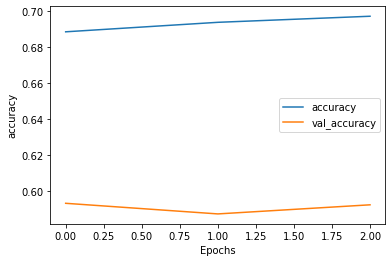

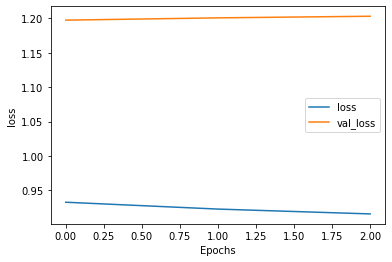

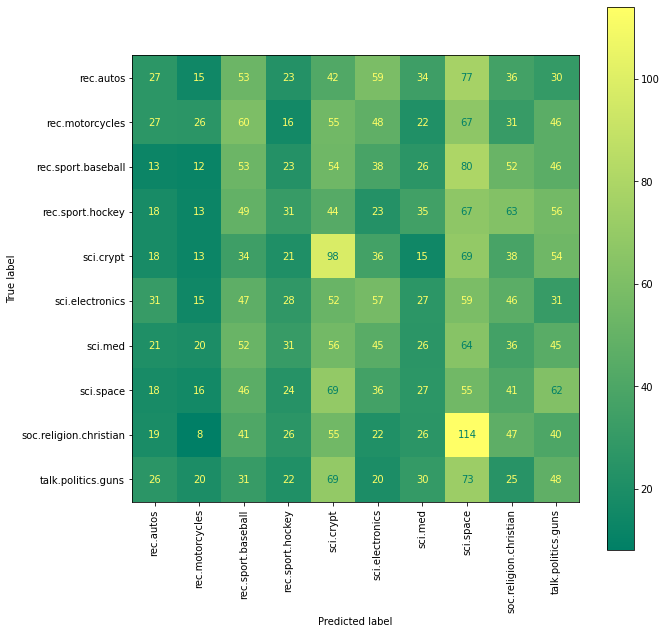

In [ ]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")        
y_pred = model.predict(X_test)
assert(len(y_test) == len(y_pred))
# rearrange y_pred with classes that have high probability
y_pred=np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=data_train.target_names)
# figure was smashed due to limited figure size we had to use matplotlib to expand the figsize 
fig, ax = plt.subplots(figsize=(10, 10))
disp = disp.plot(xticks_rotation='vertical', ax=ax, cmap='summer')

In [ ]:
# project our word2vec to check how our model was able to cluster words
# capture weights from embedding layer 
embedding_layer = model.layers[0]
# weights size should hold the vocab size and embedding dimension
weights = embedding_layer.get_weights()[0]
print("weights size = ",weights.shape)
vector_tsv = io.open('vecs.tsv', 'w', encoding='utf-8')
meta_tsv = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, weights.shape[0]):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  meta_tsv.write(word + "\n")
  vector_tsv.write('\t'.join([str(x) for x in embeddings]) + '\n')
vector_tsv.close()
meta_tsv.close()
try:
  from google.colab import files
except ImportError:
  pass
else: 
    files.download("vecs.tsv")
    files.download("meta.tsv")
# after downloading these 2 files
# you can check spherical of data classication by loading them into this url https://projector.tensorflow.org/

weights size =  (500, 128)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Model (Transformer Bert)

In [ ]:
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
train_encodings = tokenizer(data_train.data, truncation=True, padding=True, max_length=MAX_SIZE)
valid_encodings = tokenizer(data_test.data, truncation=True, padding=True, max_length=MAX_SIZE)

Loading BERT tokenizer...


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
class NewsGroupsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor([self.labels[idx]])
        return item

    def __len__(self):
        return len(self.labels)

# convert our tokenized data into a torch Dataset
train_dataset = NewsGroupsDataset(train_encodings, data_train.target)
valid_dataset = NewsGroupsDataset(valid_encodings, data_test.target)
# load the model and pass to CUDA
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(categories)).to("cuda")

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  # calculate accuracy using sklearn's function
  acc = accuracy_score(labels, preds)
  return {
      'accuracy': acc,
  }
training_args = TrainingArguments(
    output_dir='./',          
    num_train_epochs=3,              
    per_device_train_batch_size=8,  # batch size per device during training
    per_device_eval_batch_size=20,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./',            # directory for storing logs
    load_best_model_at_end=True,     # load the best model when finished training (default metric is loss)
    logging_steps=400,               # log & save weights each logging_steps
    save_steps=400,
    evaluation_strategy="steps",     # evaluate each `logging_steps`
)

trainer = Trainer(
    model=model,                         # the instantiated Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=valid_dataset,          # evaluation dataset
    compute_metrics=compute_metrics,     # the callback that computes metrics of interest
)
trainer.train()

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Step,Training Loss,Validation Loss,Accuracy
400,1.510100,0.812098,0.751463
800,0.727900,0.770264,0.784024
1200,0.493400,0.792268,0.796489
1600,0.383100,0.792386,0.804630
2000,0.233000,0.815128,0.813788


***** Running Evaluation *****
  Num examples = 3931
  Batch size = 20
Saving model checkpoint to ./checkpoint-400
Configuration saved in ./checkpoint-400/config.json
Model weights saved in ./checkpoint-400/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 3931
  Batch size = 20
Saving model checkpoint to ./checkpoint-800
Configuration saved in ./checkpoint-800/config.json
Model weights saved in ./checkpoint-800/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 3931
  Batch size = 20
Saving model checkpoint to ./checkpoint-1200
Configuration saved in ./checkpoint-1200/config.json
Model weights saved in ./checkpoint-1200/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 3931
  Batch size = 20
Saving model checkpoint to ./checkpoint-1600
Configuration saved in ./checkpoint-1600/config.json
Model weights saved in ./checkpoint-1600/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 3931
  Batch size = 20
Saving model checkpoint

TrainOutput(global_step=2217, training_loss=0.6268845912191746, metrics={'train_runtime': 1043.1342, 'train_samples_per_second': 16.988, 'train_steps_per_second': 2.125, 'total_flos': 910727718793200.0, 'train_loss': 0.6268845912191746, 'epoch': 3.0})

In [ ]:
# evaluate the current model after training
trainer.evaluate()
model_path = "20newsgroups-bert-base-uncased"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

***** Running Evaluation *****
  Num examples = 3931
  Batch size = 20


Configuration saved in 20newsgroups-bert-base-uncased/config.json
Model weights saved in 20newsgroups-bert-base-uncased/pytorch_model.bin
tokenizer config file saved in 20newsgroups-bert-base-uncased/tokenizer_config.json
Special tokens file saved in 20newsgroups-bert-base-uncased/special_tokens_map.json


('20newsgroups-bert-base-uncased/tokenizer_config.json',
 '20newsgroups-bert-base-uncased/special_tokens_map.json',
 '20newsgroups-bert-base-uncased/vocab.txt',
 '20newsgroups-bert-base-uncased/added_tokens.json')

In [ ]:
def get_prediction(text):
    # prepare our text into tokenized sequence
    inputs = tokenizer(text, padding=True, truncation=True, max_length=MAX_SIZE, return_tensors="pt").to("cuda")
    # perform inference to our model
    outputs = model(**inputs)
    # get output probabilities by doing softmax
    probs = outputs[0].softmax(1)
    print(categories)
    print(probs)
    # executing argmax function to get the candidate label
    return categories[probs.argmax()]

In [ ]:
text = """
A massive star in the last phase of its evolution, in which the star collapses, creating a volume of space-time with a gravitational field so intense that its escape velocity equals or exceeds that of light.
"""
print(get_prediction(text))

['rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns']
tensor([[0.0011, 0.0013, 0.0018, 0.0022, 0.0015, 0.0018, 0.0026, 0.9834, 0.0013,
         0.0028]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
sci.space


In [ ]:
! zip -r model.zip 20newsgroups-bert-base-uncased
try:
  from google.colab import files
except ImportError:
  pass
else: 
    files.download("model.zip")

  adding: 20newsgroups-bert-base-uncased/ (stored 0%)
  adding: 20newsgroups-bert-base-uncased/tokenizer_config.json (deflated 39%)
  adding: 20newsgroups-bert-base-uncased/special_tokens_map.json (deflated 40%)
  adding: 20newsgroups-bert-base-uncased/pytorch_model.bin (deflated 7%)
  adding: 20newsgroups-bert-base-uncased/vocab.txt (deflated 53%)
  adding: 20newsgroups-bert-base-uncased/config.json (deflated 57%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>